In [4]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from azureml.core import Workspace, Dataset

# Create workspace
subscription_id = '161c391c-34a1-495b-a7e5-a53aeefb8a6f'
resource_group = 'A5'
workspace_name = 'A5ML'

workspace = Workspace(subscription_id, resource_group, workspace_name)

# Import pca projected dataframe
dataset = Dataset.get_by_name(workspace, name='pcdf')
df = dataset.to_pandas_dataframe()
df.head()

,pc1,pc2,class
0,-62.755415,-94.071974,PRAD
1,-2.432896,90.585842,LUAD
2,-71.266853,-8.064607,PRAD
3,-84.770785,-73.244566,PRAD
4,-69.560171,-9.612940,BRCA


In [103]:
# Train test split 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras

X = df.iloc[:,0:2]
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)
# One hot encoding
y_train_dummy = pd.get_dummies(y_train)
y_test_dummy = pd.get_dummies(y_test)

In [104]:
y_test_dummy.head()

,BRCA,COAD,KIRC,LUAD,PRAD
207,0,0,0,0,1
329,1,0,0,0,0
199,0,0,0,1,0
583,0,0,1,0,0
618,0,1,0,0,0


In [140]:
import tensorflow as tf
from tensorflow import keras
  
model = keras.Sequential([
    keras.layers.Dense(10, input_shape=(2,), activation='relu'),
    keras.layers.Dense(7, activation='relu'),
    keras.layers.Dense(5, activation='sigmoid')
])

opt = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train_dummy, epochs=300)

Train on 560 samples
Epoch 1/300
560/560 [==============================] - 0s 495us/sample - loss: 2.7355 - accuracy: 0.2268
Epoch 2/300
560/560 [==============================] - 0s 38us/sample - loss: 1.3313 - accuracy: 0.2875
Epoch 3/300
560/560 [==============================] - 0s 38us/sample - loss: 1.2188 - accuracy: 0.3375
Epoch 4/300
560/560 [==============================] - 0s 64us/sample - loss: 1.0738 - accuracy: 0.3268
Epoch 5/300
560/560 [==============================] - 0s 41us/sample - loss: 1.0036 - accuracy: 0.3179
Epoch 6/300
560/560 [==============================] - 0s 37us/sample - lo

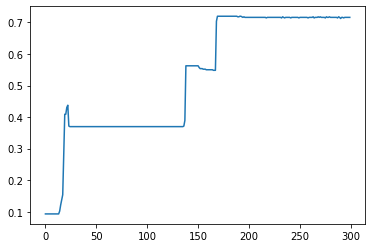

In [136]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])

In [137]:
# Get prediction column

# Get calculation probabilites dataframe
y_pred = model.predict(X_test)
y_pred_dummy = y_test_dummy.iloc[0:0]
y_pred_dummy = y_pred_dummy.append(pd.DataFrame(y_pred, columns=y_pred_dummy.columns), ignore_index=True)


# Get the label column
y_test_pred = y_pred_dummy.idxmax(axis=1)

In [138]:
# Get prediction accuracy
sum(1 for x,y in zip(pd.Series.tolist(y_test), pd.Series.tolist(y_test_pred)) if x == y) / len(pd.Series.tolist(y_test))

0.6639004149377593

In [139]:
# Get confusion matrix
from sklearn.metrics import confusion_matrix

y_pred_dummy = y_test_dummy.iloc[0:0]
nn_confusion_matrix = y_pred_dummy.append(pd.DataFrame(confusion_matrix(y_test, y_test_pred), columns=y_pred_dummy.columns), ignore_index=True)
nn_confusion_matrix

,BRCA,COAD,KIRC,LUAD,PRAD
0,89,0,0,0,4
1,26,0,0,0,0
2,0,0,38,0,0
3,44,0,3,0,0
4,4,0,0,0,33


In [147]:
# Train Logistic Regression
from sklearn.linear_model import LogisticRegression
model_mlr = LogisticRegression(random_state=0).fit(X_train, y_train)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [153]:
# Predict & Accuracy calculation
y_pred_test_mlr = model_mlr.predict(X_test)
sum(1 for x,y in zip(pd.Series.tolist(y_test), y_pred_test_mlr) if x == y) / len(pd.Series.tolist(y_test))

0.966804979253112

In [155]:
# Get confusion matrix for multiclass logistic regression
nn_confusion_matrix_mlr = y_pred_dummy.append(pd.DataFrame(confusion_matrix(y_test, y_pred_test_mlr), columns=y_pred_dummy.columns), ignore_index=True)
nn_confusion_matrix_mlr

,BRCA,COAD,KIRC,LUAD,PRAD
0,93,0,0,0,0
1,0,22,0,4,0
2,0,0,38,0,0
3,2,2,0,43,0
4,0,0,0,0,37
